In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [45]:
file_path = "Churn_Modelling.csv"
df = pd.read_csv(file_path)

In [46]:
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)

X = df.drop(columns=["Exited"])
y = df["Exited"]

In [47]:
cat_features = ["Geography", "Gender"]
num_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]
preprocessor= ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)
X_test_processed = preprocessor.transform(X_test)

In [50]:
model= Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_test_processed, y_test),
                    epochs=50, batch_size=32, verbose=1)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6230 - loss: 1.5467 - val_accuracy: 0.7735 - val_loss: 0.9570
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7120 - loss: 0.9516 - val_accuracy: 0.8075 - val_loss: 0.6080
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7437 - loss: 0.6746 - val_accuracy: 0.7910 - val_loss: 0.5367
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7527 - loss: 0.5945 - val_accuracy: 0.7740 - val_loss: 0.5264
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7613 - loss: 0.5647 - val_accuracy: 0.8195 - val_loss: 0.4608
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7655 - loss: 0.5425 - val_accuracy: 0.7770 - val_loss: 0.5095
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7666 - loss: 0.5565 - val_accuracy: 0.7990 - val_loss: 0.4843
Epoch 8/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7655 - loss: 0.5394 - val_accuracy: 0.

In [53]:
pred=model.predict(X_test_processed)
y_pred=np.where(pred>0.637, 1, 0)
print(classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1593
           1       0.60      0.62      0.61       407

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



<Axes: >

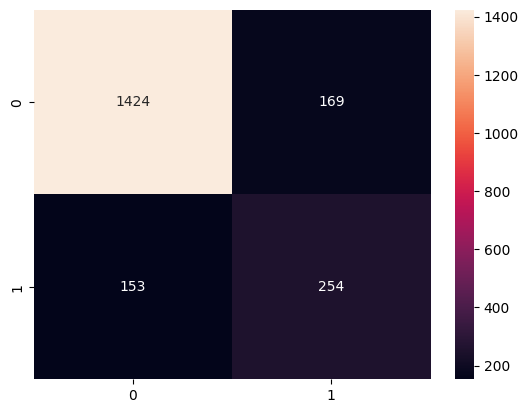

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

Text(0.5, 1.0, 'Receiver Operating Characteristic')

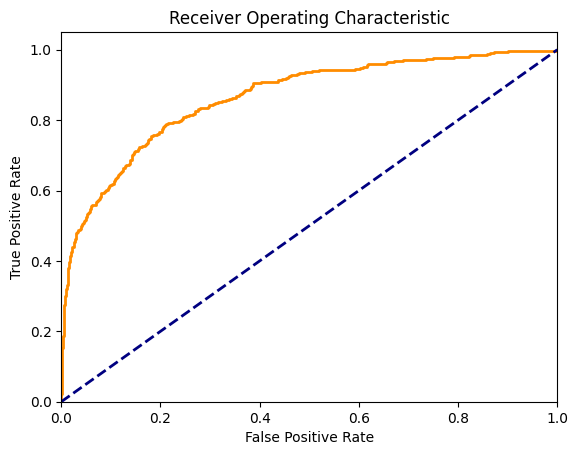

In [55]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')


In [56]:
import joblib
joblib.dump(preprocessor, 'preprocessor_beta2.pkl')

['preprocessor_beta2.pkl']

In [57]:
model.save("model_beta2_1.keras")